In [72]:
import sys
import pandas as pd
print("Pandas version: ", pd.__version__)
print()
pd.set_option('display.max_rows', 500)
import numpy as np
print("Numpy version: ", np.__version__)
print()
print("system version: ", sys.version)

from datetime import datetime as dt
import calendar

import matplotlib.pyplot as plt
%matplotlib inline

import seaborn as sns
sns.set(color_codes=True)

from IPython.display import Image

#customizable plotting parameters
plt.rcParams["figure.figsize"] = (12,5)
plt.rcParams["xtick.labelsize"] = 15
plt.rcParams["ytick.labelsize"] = 15
plt.rcParams["axes.labelsize"] = 20
plt.rcParams['legend.fontsize'] = 15
plt.rcParams['axes.titlesize'] = 20
plt.rcParams['axes.titlepad'] = 15
plt.rcParams['axes.labelpad'] = 15

#autosaves work so we dont have to!
%autosave 120

Pandas version:  0.20.2

Numpy version:  1.12.1

system version:  3.6.1 |Anaconda custom (x86_64)| (default, May 11 2017, 13:04:09) 
[GCC 4.2.1 Compatible Apple LLVM 6.0 (clang-600.0.57)]


Autosaving every 120 seconds


### Obtaining the Data

The gala will be held on May 30th! We wish to give WTWY 2 weeks to in order to implement our findings!

In order to use the latest results, we will be using MTA data that relates to 3 weeks prior to the 2 week implemtation process.

Below we will clean up/standardize the headers in addition to adding useful information to the datframe i.e. turnstile.

We will also pickle our resulting dataframe in order to ensure we can obtain the original information with speed should it be required later on.

In [14]:
may13 = pd.read_csv("http://web.mta.info/developers/data/nyct/turnstile/turnstile_170513.txt")
may06 = pd.read_csv("http://web.mta.info/developers/data/nyct/turnstile/turnstile_170506.txt")
april29 = pd.read_csv("http://web.mta.info/developers/data/nyct/turnstile/turnstile_170429.txt")

master_df = pd.concat([may13, may06, april29])

master_df = master_df.rename(columns=lambda x: x.strip()) #rid of whitespace
master_df = master_df.rename(columns=lambda x: x.lower()) #lower case for ease of typing

master_df["date"] = master_df["date"].apply(lambda x: dt.strptime(x, '%m/%d/%Y')) #make datetime objects
master_df['week_day_num'] = master_df['date'].dt.dayofweek #numeric indicies that relate to day of week
master_df['week_day_name'] = master_df["date"].apply(lambda x: calendar.day_name[x.dayofweek]) #names of the days of week
master_df["time"] = master_df["time"].apply(lambda x: dt.strptime(x, '%H:%M:%S').time()) #makes time object
master_df['turnstile'] = master_df['c/a'] + " "+ master_df['scp'] #identifies unique turnstile

master_df.sort_values(["c/a", "scp", "date", "time"], inplace=True)

master_df.reset_index(inplace=True)

del master_df['index']

master_df.to_pickle("master_df.pkl") #saves the clean resuting dataframe for ease of access in the future.

In [2]:
master_df = pd.read_pickle("master_df.pkl")

In [3]:
master_df.head() #nice and clean!

c/a  unit       scp station linename division       date      time  \
0  A002  R051  02-00-00   59 ST  NQR456W      BMT 2017-04-22  00:00:00   
1  A002  R051  02-00-00   59 ST  NQR456W      BMT 2017-04-22  04:00:00   
2  A002  R051  02-00-00   59 ST  NQR456W      BMT 2017-04-22  08:00:00   
3  A002  R051  02-00-00   59 ST  NQR456W      BMT 2017-04-22  12:00:00   
4  A002  R051  02-00-00   59 ST  NQR456W      BMT 2017-04-22  16:00:00   

      desc  entries    exits  week_day_num week_day_name      turnstile  
0  REGULAR  6148025  2082120             5      Saturday  A002 02-00-00  
1  REGULAR  6148080  2082123             5      Saturday  A002 02-00-00  
2  REGULAR  6148101  2082157             5      Saturday  A002 02-00-00  
3  REGULAR  6148224  2082251             5      Saturday  A002 02-00-00  
4  REGULAR  6148524  2082316             5      Saturday  A002 02-00-00

### Interesting observation!

It seems that the entries and exits are accumalted values. Thus, we have to find the differences between subsequent entries at the **turnstile** level.

In [4]:
#turnstile level for entries
master_df['new_entries'] = master_df.groupby(['turnstile'])['entries'].transform(lambda x: x.diff())

#turnstile level for exits
master_df['new_exits'] = master_df.groupby(['turnstile'])['exits'].transform(lambda x: x.diff())

#the starting point of our differences will have NaN's, lets change those to 0's!
master_df['new_entries'].fillna(0, inplace=True)
master_df['new_exits'].fillna(0, inplace=True)

#it does not make sense to have negative values for entries or exits!
master_df = master_df[(master_df.new_entries > 0) & (master_df.new_exits > 0)]

#the total traffic at a turnstile in a given block of time (4hrs) is the sum of entries and exits!
master_df['traffic'] = master_df[['new_entries', 'new_exits']].sum(axis=1)

#since our analysis is at the turnstile level, we assume an upper bound of 5000 individuals through a turnstile
#in a block of time.
master_df = master_df[master_df['traffic'] <= 5000]

average_traffic_per_day = int((sum(master_df['traffic'])/3)/7)

#let's take a look!
master_df.head()

c/a  unit       scp station linename division       date      time  \
1  A002  R051  02-00-00   59 ST  NQR456W      BMT 2017-04-22  04:00:00   
2  A002  R051  02-00-00   59 ST  NQR456W      BMT 2017-04-22  08:00:00   
3  A002  R051  02-00-00   59 ST  NQR456W      BMT 2017-04-22  12:00:00   
4  A002  R051  02-00-00   59 ST  NQR456W      BMT 2017-04-22  16:00:00   
5  A002  R051  02-00-00   59 ST  NQR456W      BMT 2017-04-22  20:00:00   

      desc  entries    exits  week_day_num week_day_name      turnstile  \
1  REGULAR  6148080  2082123             5      Saturday  A002 02-00-00   
2  REGULAR  6148101  2082157             5      Saturday  A002 02-00-00   
3  REGULAR  6148224  2082251             5      Saturday  A002 02-00-00   
4  REGULAR  6148524  2082316             5      Saturday  A002 02-00-00   
5  REGULAR  6148910  2082368             5      Saturday  A002 02-00-00   

   new_entries  new_exits  traffic  
1         55.0        3.0     58.0  
2         21.0       34.0     55.0  
3        123.0       94.0    217.0  
4        300.0       65.0    365.0  
5        386.0       52.0    438.0

In [ ]:
print("Average Traffic through turnstiles per day: ", average_traffic_per_day)

In [6]:
station_by_day = pd.DataFrame(master_df.groupby(['station', 'week_day_name', 'week_day_num', 'turnstile']).sum()['traffic']).reset_index()

From NYC MTA we obtain the following top 5 stations in the city!

In [7]:
top_5_list = ['TIMES SQ-42 ST', 'GRD CNTRL-42 ST', '34 ST-HERALD SQ', '14 ST-UNION SQ', '34 ST-PENN STA']

In [8]:
top_5_stations = station_by_day[station_by_day['station'].isin(top_5_list)] #subset the dataframe.

In [9]:
top_5_grouped = pd.DataFrame(top_5_stations.groupby(['station']).sum()['traffic']).reset_index()

In [10]:
top_5_grouped.sort_values(by='traffic', ascending=False, inplace=True)

In [11]:
top_5_grouped.reset_index(inplace=True)
del top_5_grouped['index']

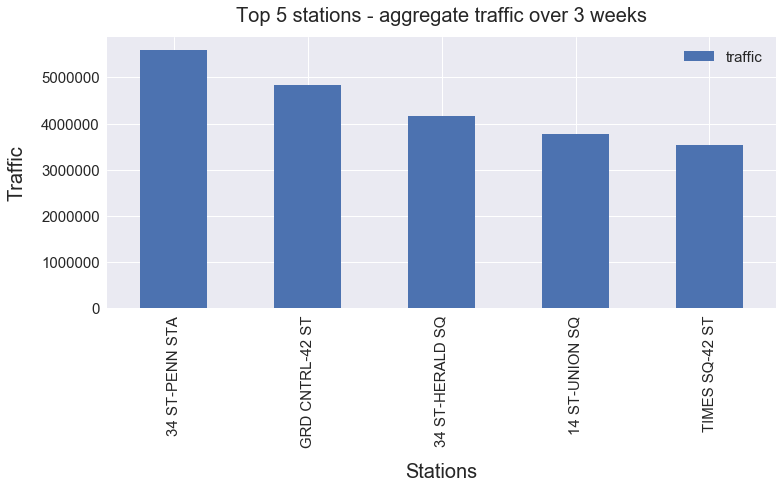

In [12]:
top_5_grouped.plot.bar(x='station')
plt.title("Top 5 stations - aggregate traffic over 3 weeks")
plt.xlabel("Stations")
plt.ylabel("Traffic")
plt.savefig("top_5_aggregate_traffic.png")


In [66]:
def time_bin(x):
    if x < datetime.time(2):
        return "00:00-01:59"
    elif x < datetime.time(6):
        return "02:00-05:59"
    elif x < datetime.time(10):
        return "06:00-09:59"
    elif x < datetime.time(14):
        return "10:00-13:59"
    elif x < datetime.time(18):
        return "14:00-17:59"
    elif x < datetime.time(22):
        return "18:00- 21:59"
    else:
        return "22:00-23:59"
master_df["Time_Bin"] = master_df["time"].apply(time_bin)

In [67]:
time_breakdown = pd.DataFrame(master_df[master_df['station'].isin(top_5_list)].groupby(['station','Time_Bin']).sum()['traffic']).reset_index()

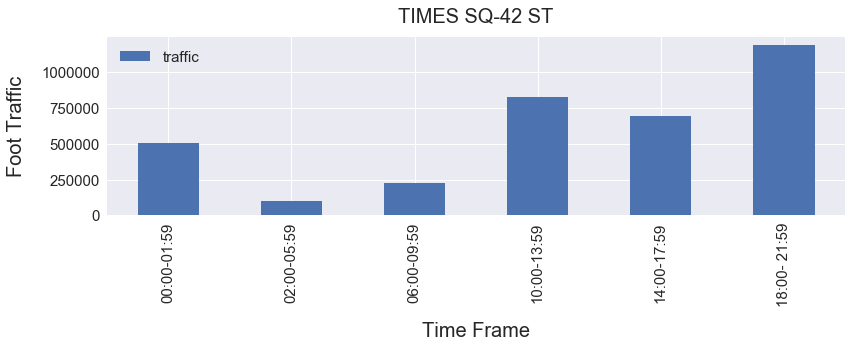

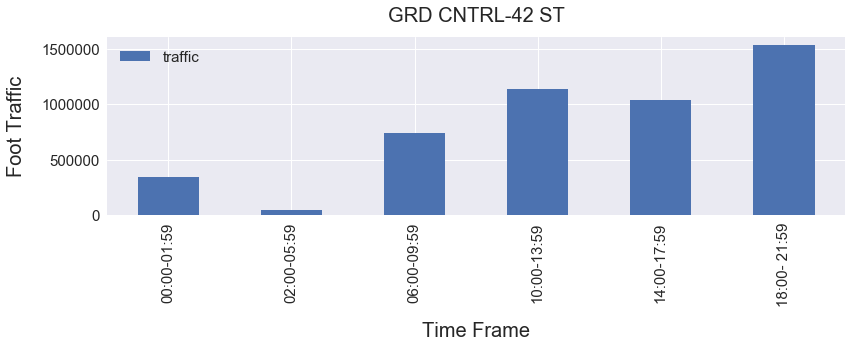

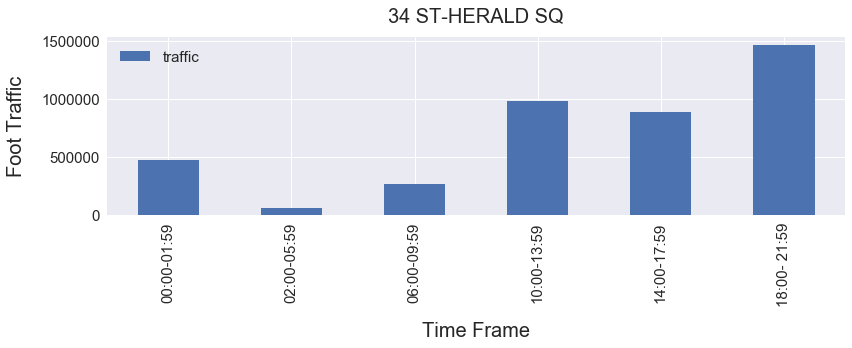

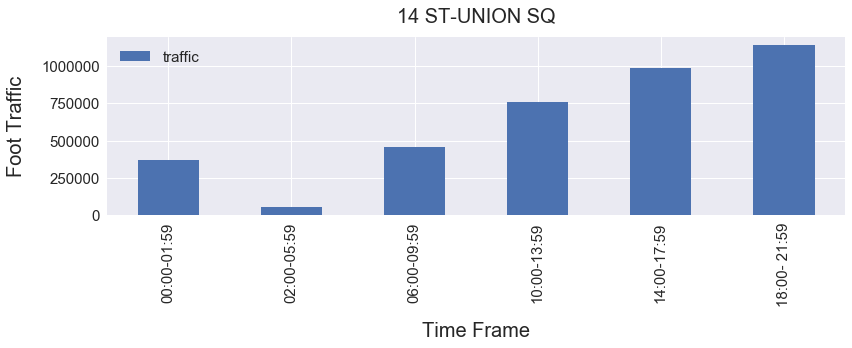

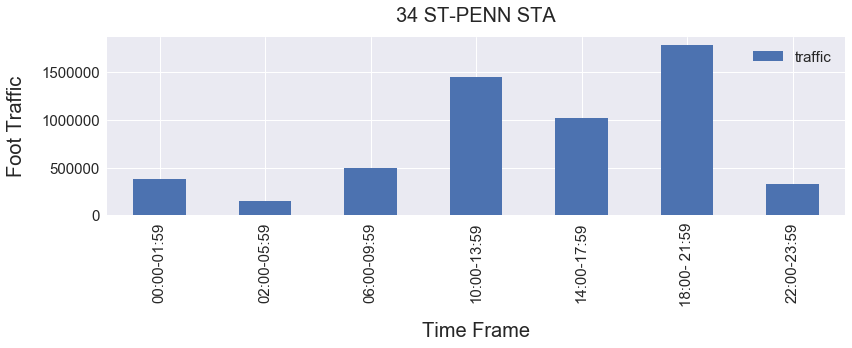

In [71]:
for i in top_5_list:
    time_breakdown[time_breakdown['station']==i].set_index('Time_Bin').plot(kind='bar')
    plt.title(i)
    plt.xlabel("Time Frame")
    plt.ylabel("Foot Traffic")
    plt.tight_layout()
    plt.savefig(i+" traffic_by_time.png")

In [154]:
station_day_breakdown_df = station_by_day.groupby(['station', 'week_day_num']).sum().reset_index()

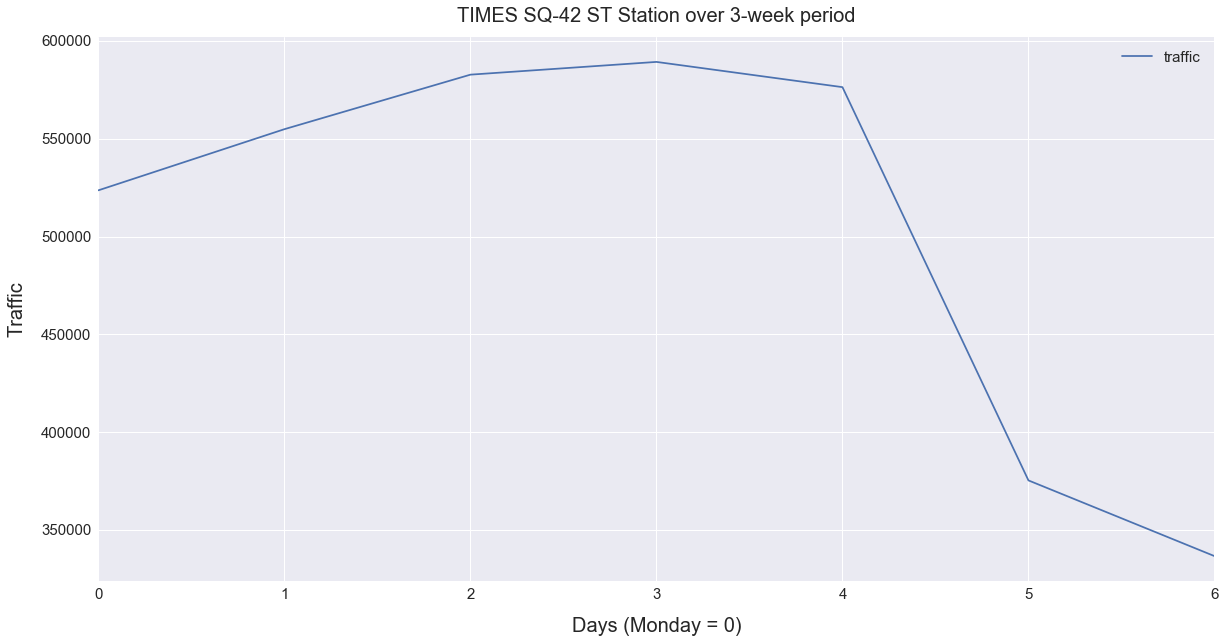

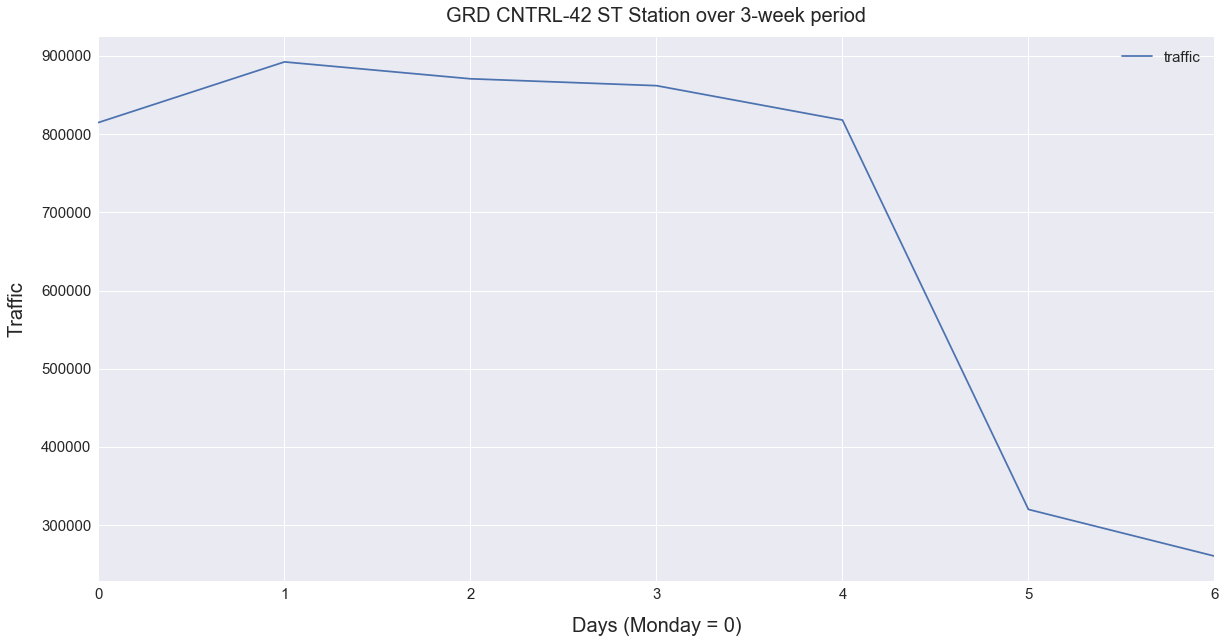

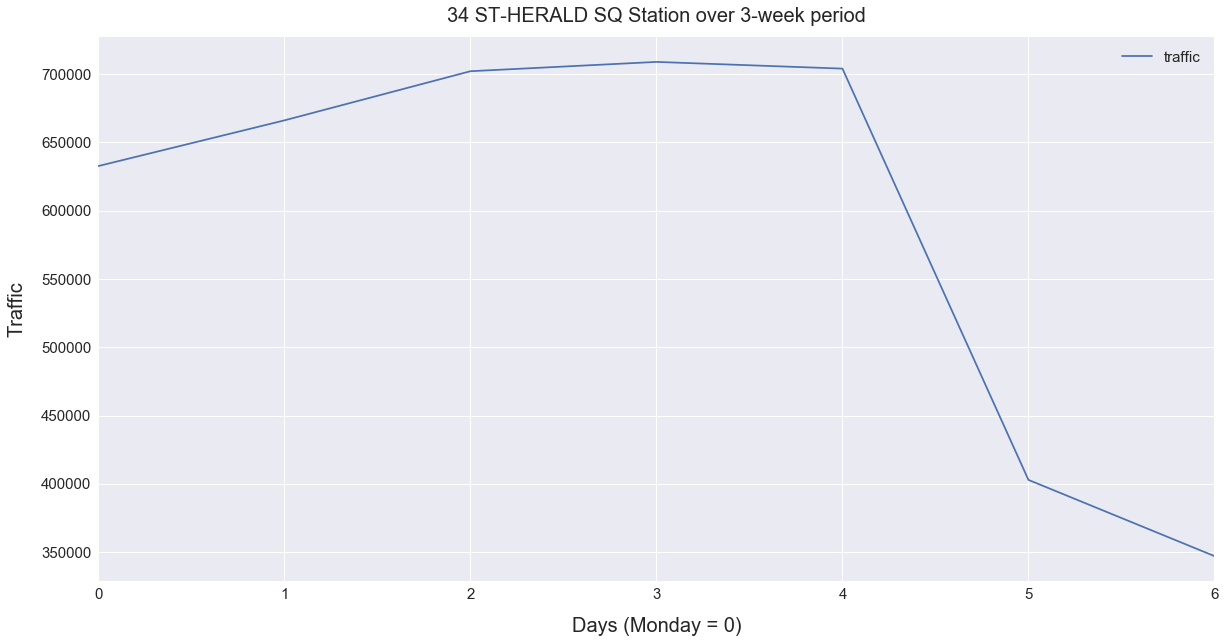

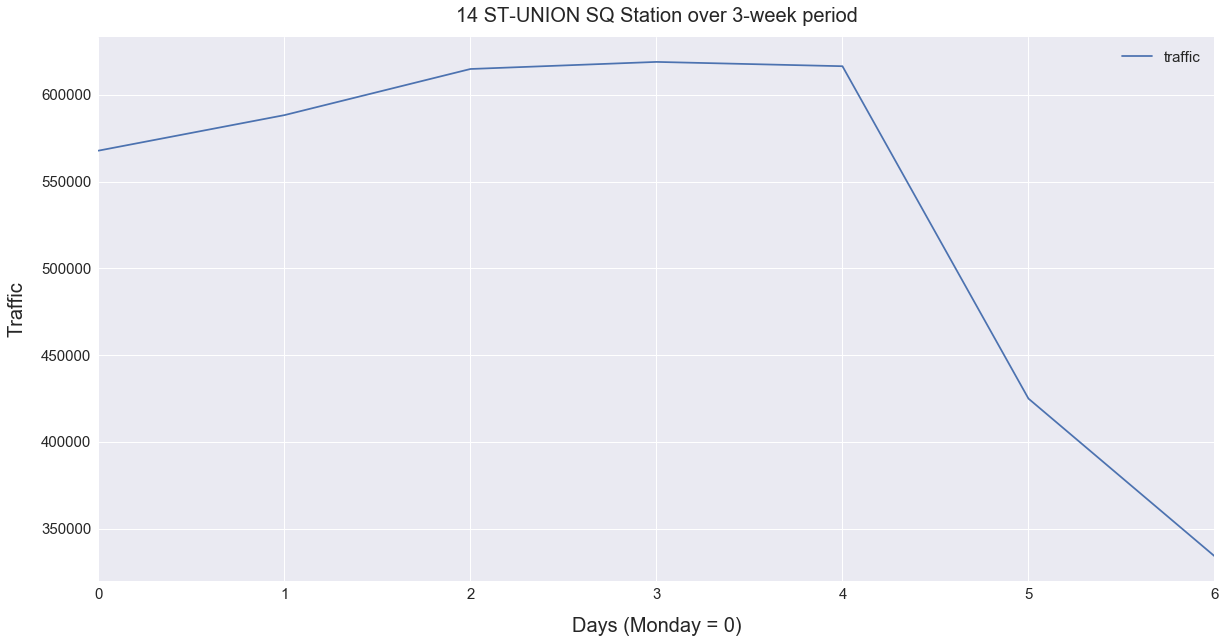

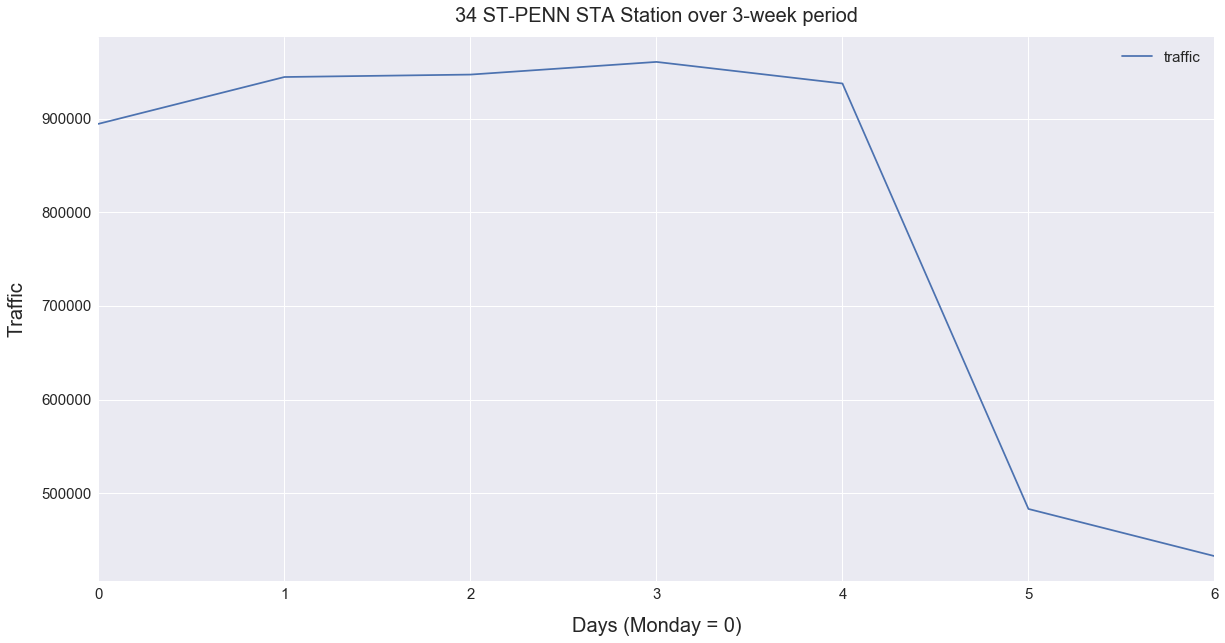

In [155]:
for i in top_5_list:
    station_day_breakdown_df[station_day_breakdown_df['station'] == i].set_index('week_day_num').plot()
    plt.title(i+" Station over 3-week period")
    plt.xlabel("Days (Monday = 0)")
    plt.ylabel("Traffic")
    plt.savefig(i+".png")

### Demograhics

The demographic information for Time-Sq, Grand-Central, Herald-Sq and Penn-Station

Time-Sq, Grand-Central, Herald-Sq and Penn Station are all located in the same census tract. This is great news as we can aggregate demographic information for 4/5 top stations!

Below is an image of the census tract!

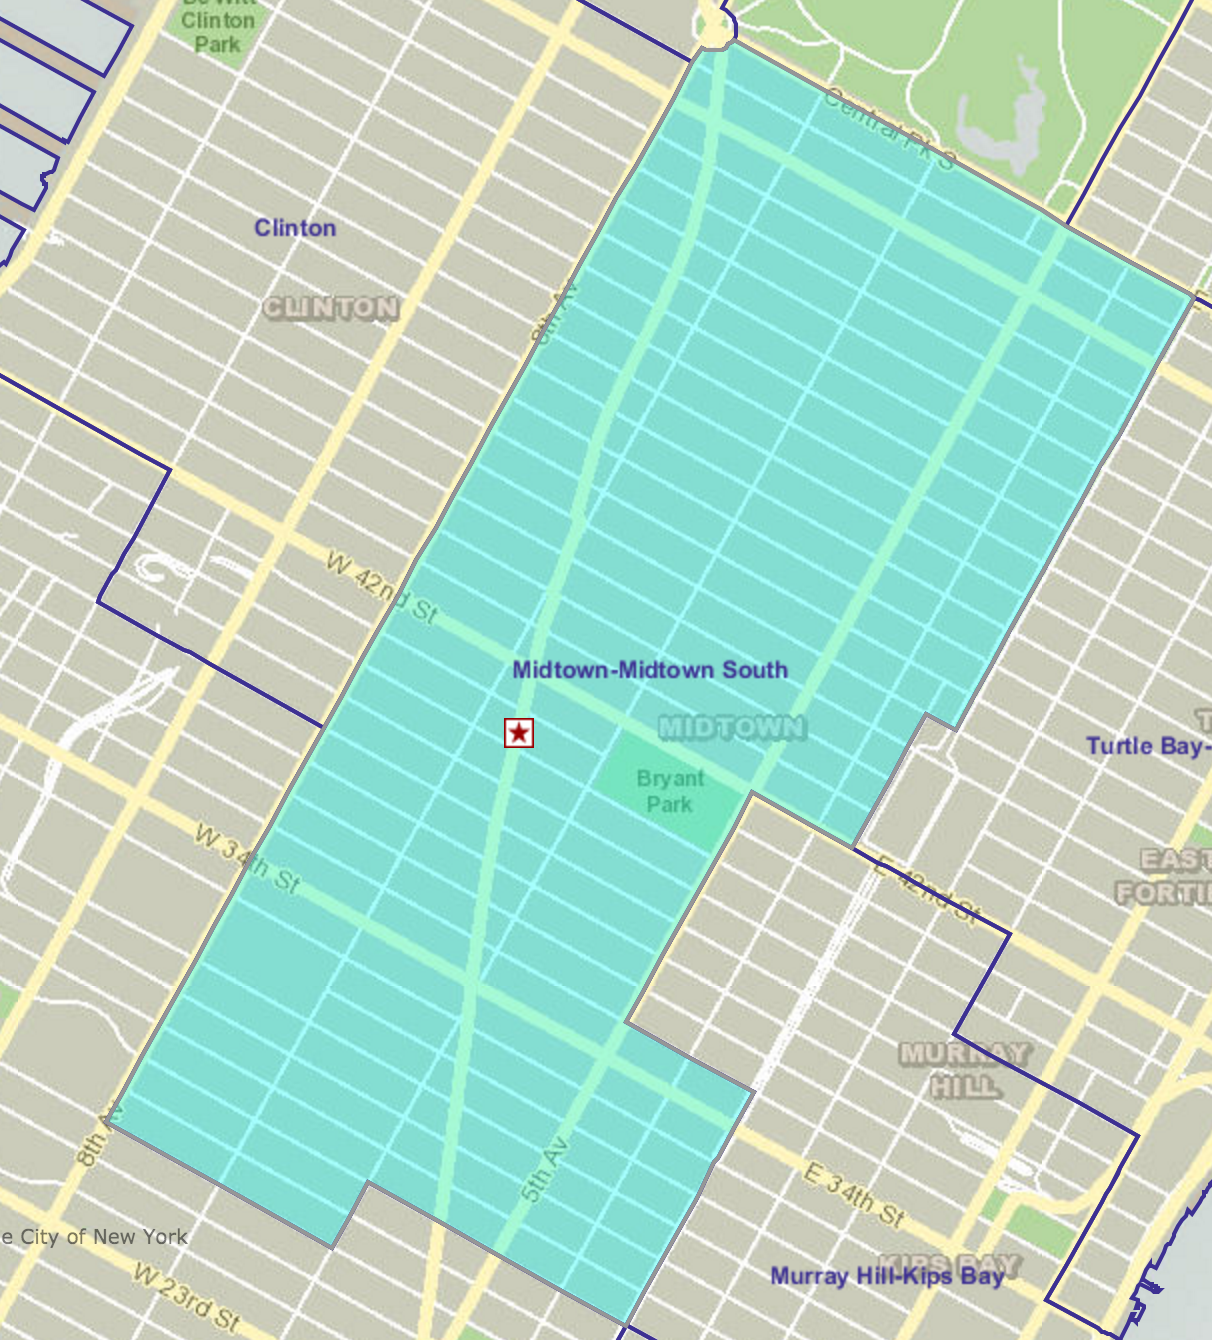

In [156]:
Image("midtown.jpg")

Let's look at some key target demographics!

In [1]:
gender_denisty_dict = {"Female": 51.7, "Male": 48.2}

age_density_dict = {"20-24":11.5, "25-29":15.9, "30-34":11.9, "35-39": 8.6}


NameError: name 'pd' is not defined

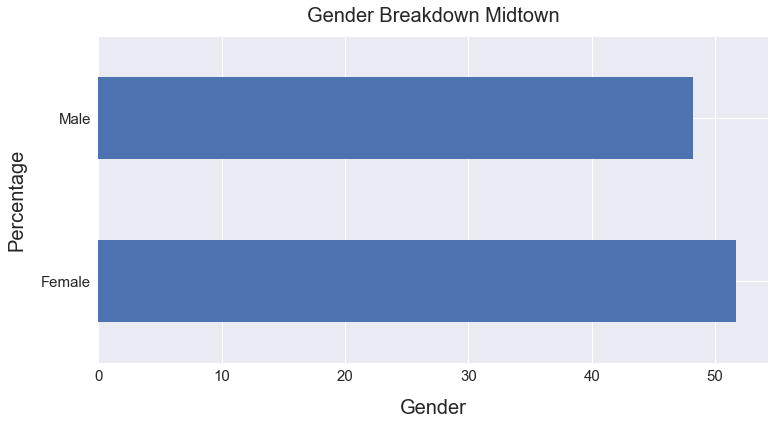

In [158]:
plt.figure(figsize=(12, 6))
pd.Series(gender_denisty_dict).plot(kind="barh")
plt.xlabel("Gender")
plt.ylabel("Percentage")
plt.title("Gender Breakdown Midtown")
plt.tight_layout()
plt.savefig("Gender_breakdown_midtown.png")

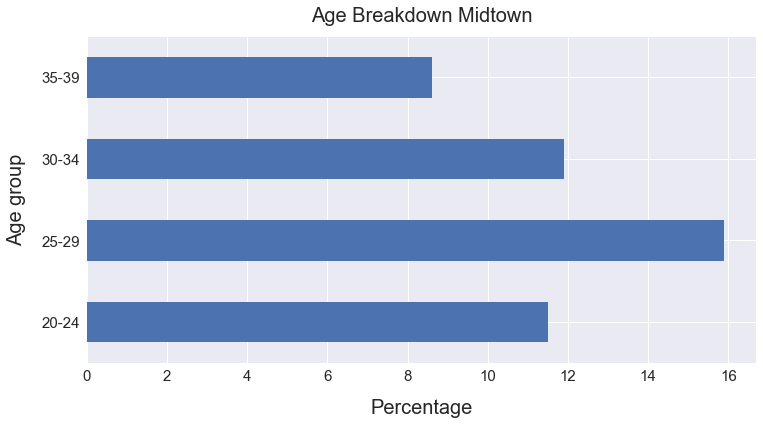

In [179]:
plt.figure(figsize=(12, 6))
pd.Series(age_density_dict).plot(kind="barh")
plt.xlabel("Percentage")
plt.ylabel("Age group")
plt.title("Age Breakdown Midtown")
plt.tight_layout()
plt.savefig("Age_breakdown_Midtown")

In [161]:
midtown_demo = pd.read_csv("midtown_agg_demo.csv")

In [162]:
del midtown_demo['Unnamed: 3']
del midtown_demo['Unnamed: 4']
midtown_demo.dropna(inplace=True)

In [163]:
midtown_demo['Percent'] = midtown_demo['Percent'].apply(lambda x: str(x))
midtown_demo['Percent'] = midtown_demo['Percent'].apply(lambda x: float(x.strip("%")))

In [164]:
def graph(col1, col2):
    """
    Col1 and Col2 are pandas series
    """
    
    pd.Series(dict(list(zip(col1,col2)))).sort_values().plot(kind='barh')
    plt.xlabel("Percent")

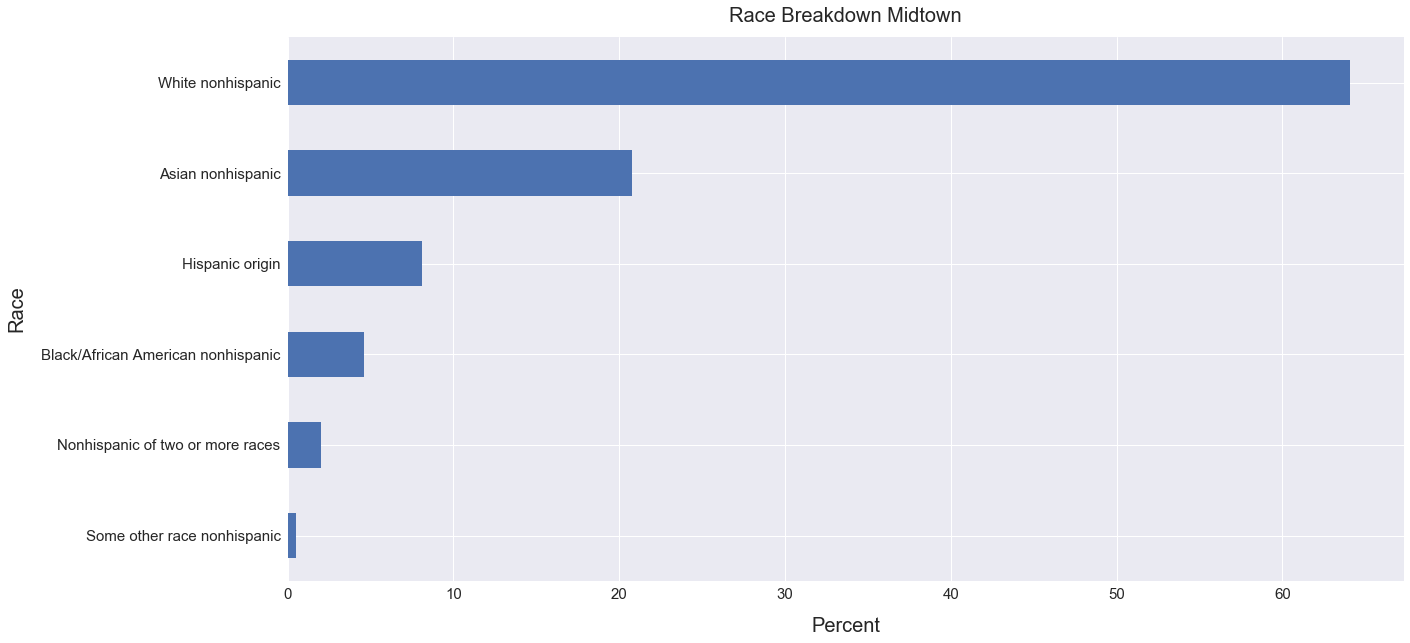

In [165]:
graph(midtown_demo['Race'], midtown_demo['Percent'])
plt.title("Race Breakdown Midtown")
plt.ylabel("Race")
plt.tight_layout()
plt.savefig("Race_breakdown_midtown.png")

In [166]:
midtown_asian_pop = pd.read_csv("midtown_asian_breakdown.csv")

In [167]:
midtown_asian_pop.dropna(axis=1, inplace=True)

In [168]:
midtown_asian_pop.drop([0,14,15], inplace=True)

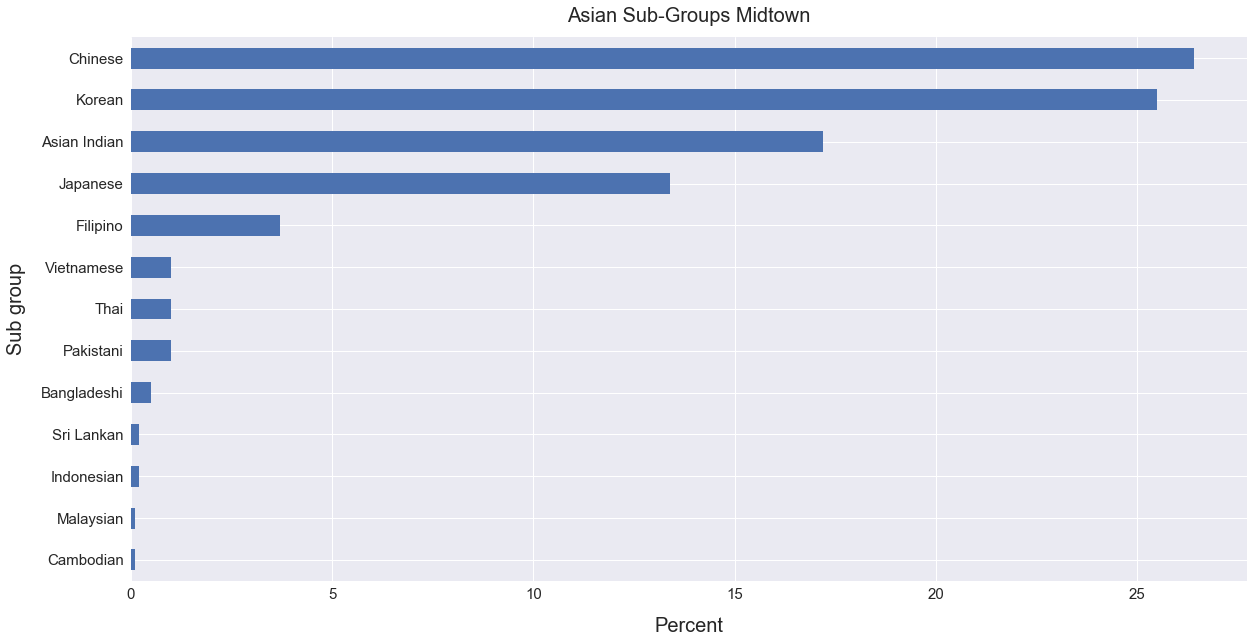

In [204]:
graph(midtown_asian_pop['SELECTED ASIAN SUBGROUPS'], midtown_asian_pop['Percent'])
plt.ylabel("Sub group")
plt.title("Asian Sub-Groups Midtown")
plt.tight_layout()
plt.savefig("asian breakdown midtown.png")

In [184]:
midtown_hispanic_pop = pd.read_csv("midtown_hispanic_breakdown.csv")
midtown_hispanic_pop.dropna(axis=1, inplace=True)

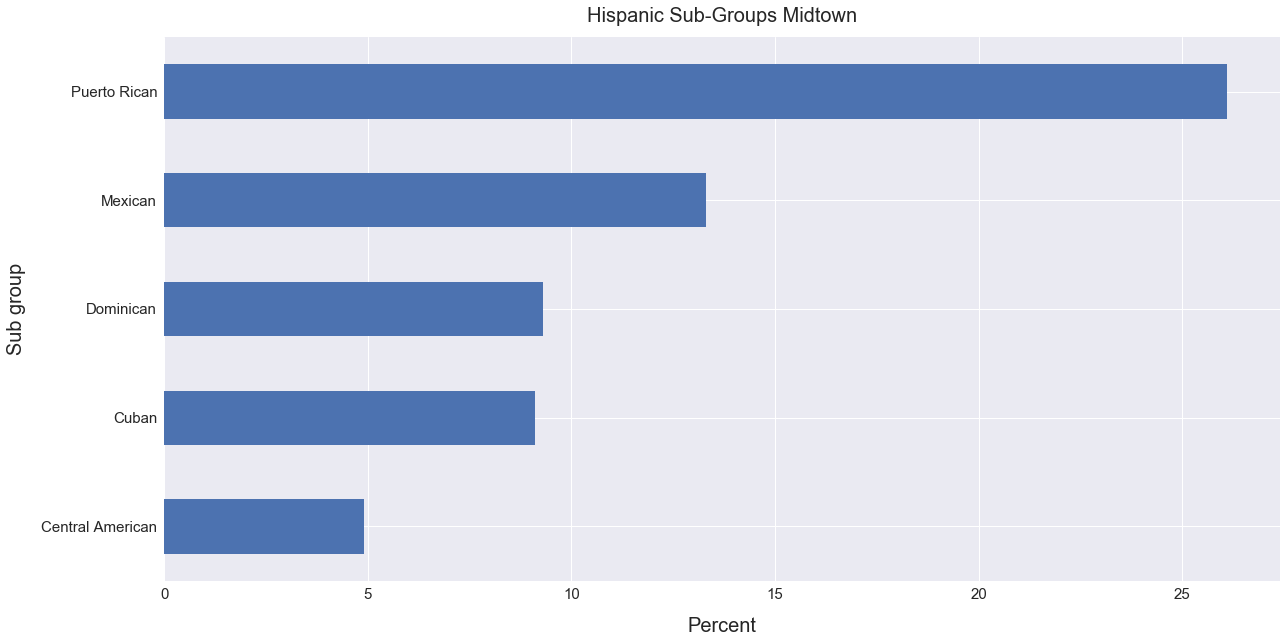

In [203]:
graph(midtown_hispanic_pop['hispanic_subgroup'], midtown_hispanic_pop['Percent'])
plt.ylabel("Sub group")
plt.title("Hispanic Sub-Groups Midtown")
plt.tight_layout()
plt.savefig("hispanic breakdown midtown.png")

In [170]:
midtown_income = pd.read_csv("midtown_income.csv")
midtown_income.dropna(axis=1, inplace=True)

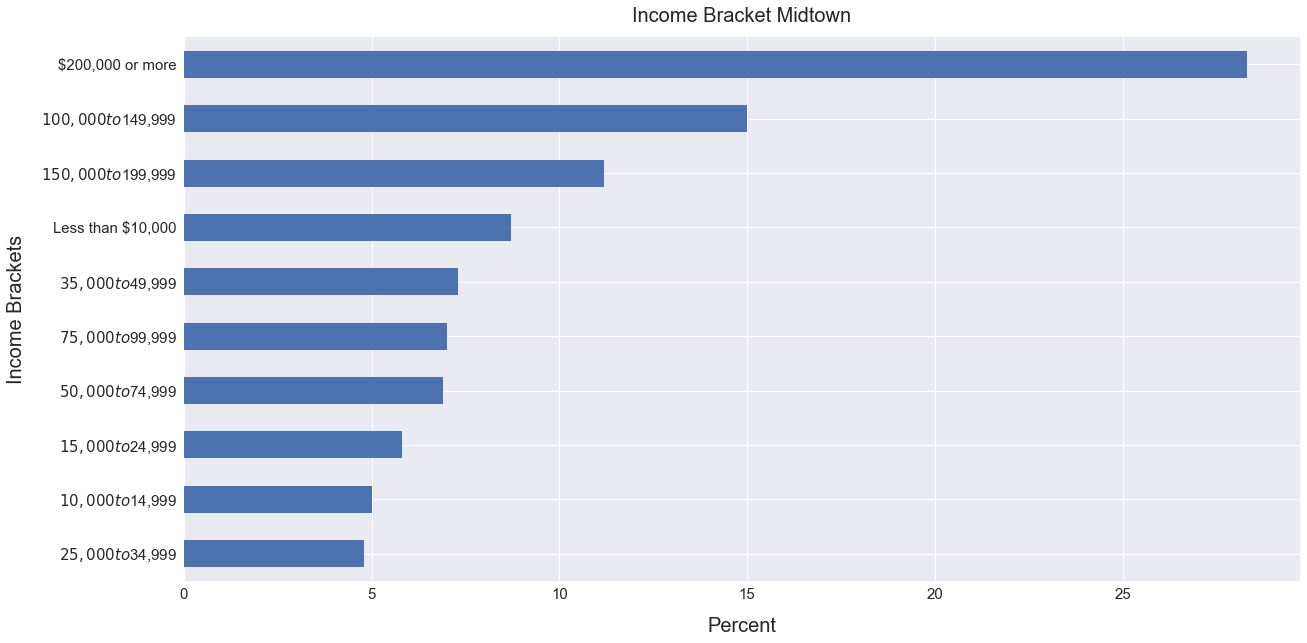

In [215]:
graph(midtown_income['INCOME AND BENEFITS'], midtown_income['Percentage'])
plt.title("Income Bracket Midtown")
plt.ylabel("Income Brackets")
plt.tight_layout()
plt.savefig("Income_midtown_graph.png")

Let's at some key stats for out last popular station - Union Sq

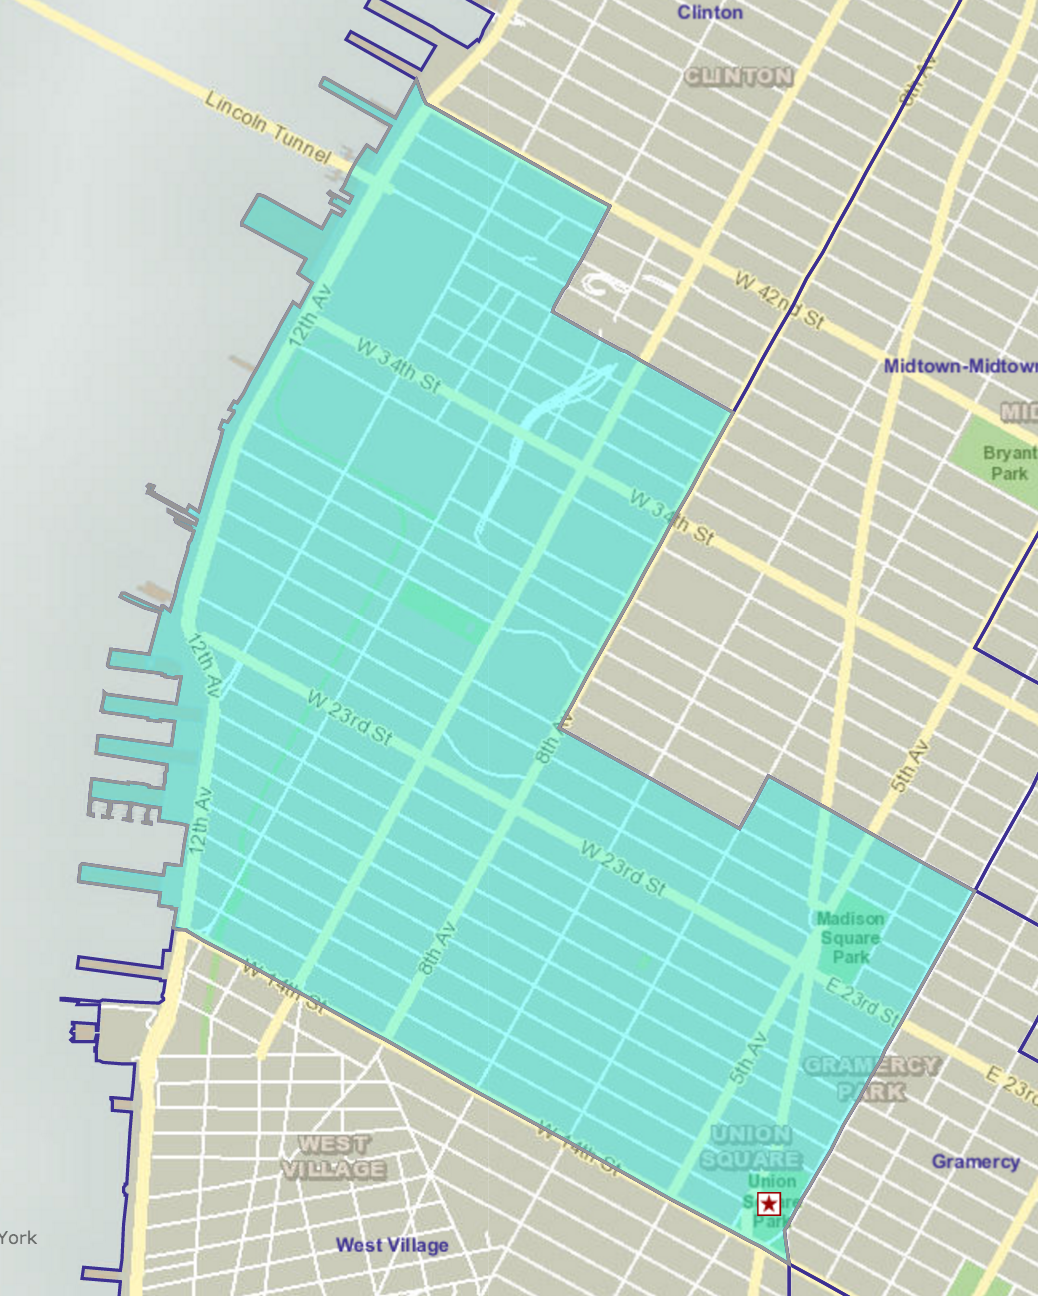

In [172]:
Image("union.png")

In [174]:
gender_denisty_dict_union = {"Female": 48.7, "Male": 51.3}

age_density_dict_union = {"20-24":8.7, "25-29":13.8, "30-34":12.6, "35-39": 9.5}


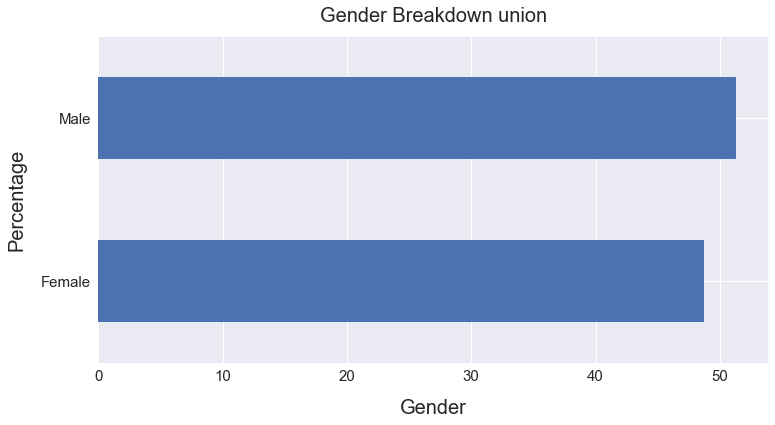

In [175]:
plt.figure(figsize=(12, 6))
pd.Series(gender_denisty_dict_union).plot(kind="barh")
plt.xlabel("Gender")
plt.ylabel("Percentage")
plt.title("Gender Breakdown union")
plt.tight_layout()
plt.savefig("Gender_breakdown_union.png")

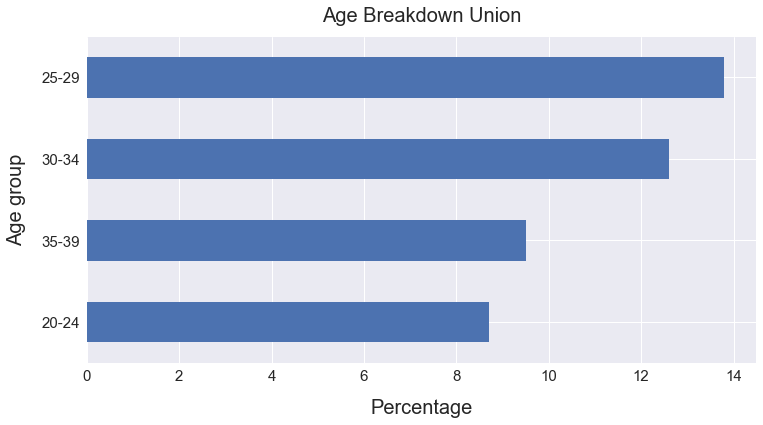

In [178]:
plt.figure(figsize=(12, 6))
pd.Series(age_density_dict_union).sort_values().plot(kind="barh")
plt.xlabel("Percentage")
plt.ylabel("Age group")
plt.title("Age Breakdown Union")
plt.tight_layout()
plt.savefig("Age_breakdown_Union")

In [197]:
union_agg_demo = pd.read_csv("union_agg_demo.csv")

In [198]:
del union_agg_demo['Unnamed: 3']
union_agg_demo.drop([6], inplace=True)

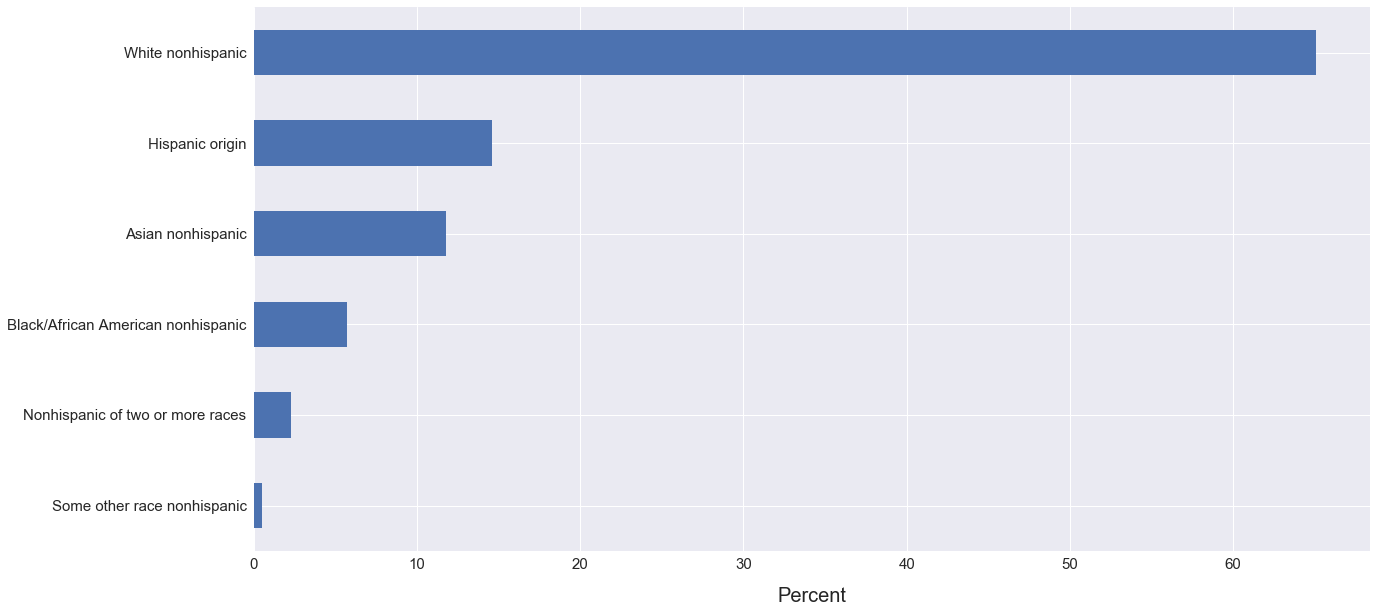

In [200]:
graph(union_agg_demo['RACE'], union_agg_demo['Percent'])

In [208]:
union_asian = pd.read_csv("union_asian_breakdown.csv")

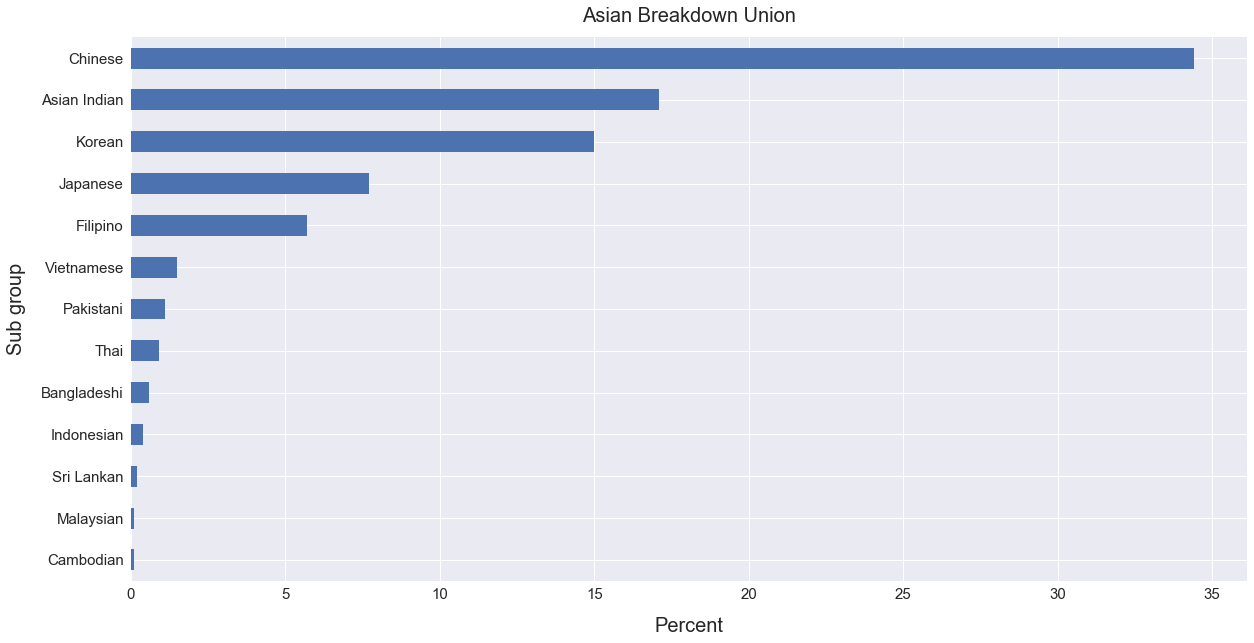

In [209]:
union_asian.dropna(axis=1, inplace=True)
graph(union_asian['SELECTED ASIAN SUBGROUPS'], union_asian['Percent'])
plt.ylabel("Sub group")
plt.title("Asian Breakdown Union")
plt.tight_layout()
plt.savefig("Asian breakdown union.png")

In [213]:
union_hispanic = pd.read_csv("union_hispanic_breakdon.csv")

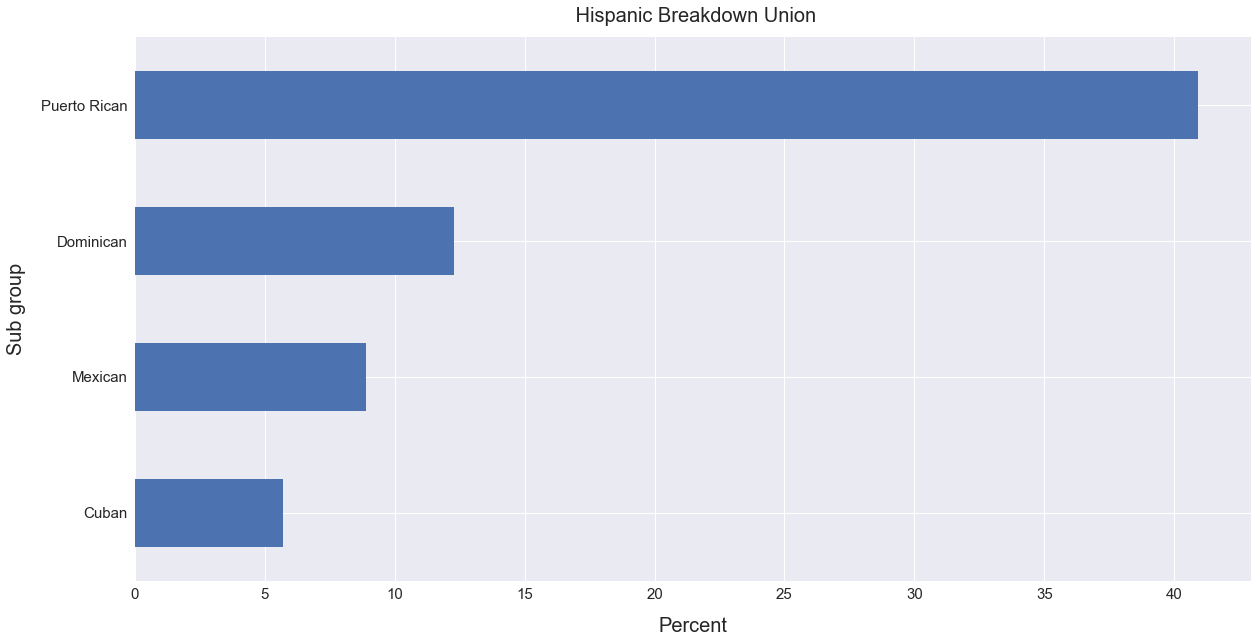

In [214]:
graph(union_hispanic['Hispanic_subgroup'], union_hispanic['Percent'])
plt.title(" Hispanic Breakdown Union")
plt.ylabel("Sub group")
plt.tight_layout()
plt.savefig("hispanic breakdown union.png")

In [216]:
union_income = pd.read_csv("union_income.csv")

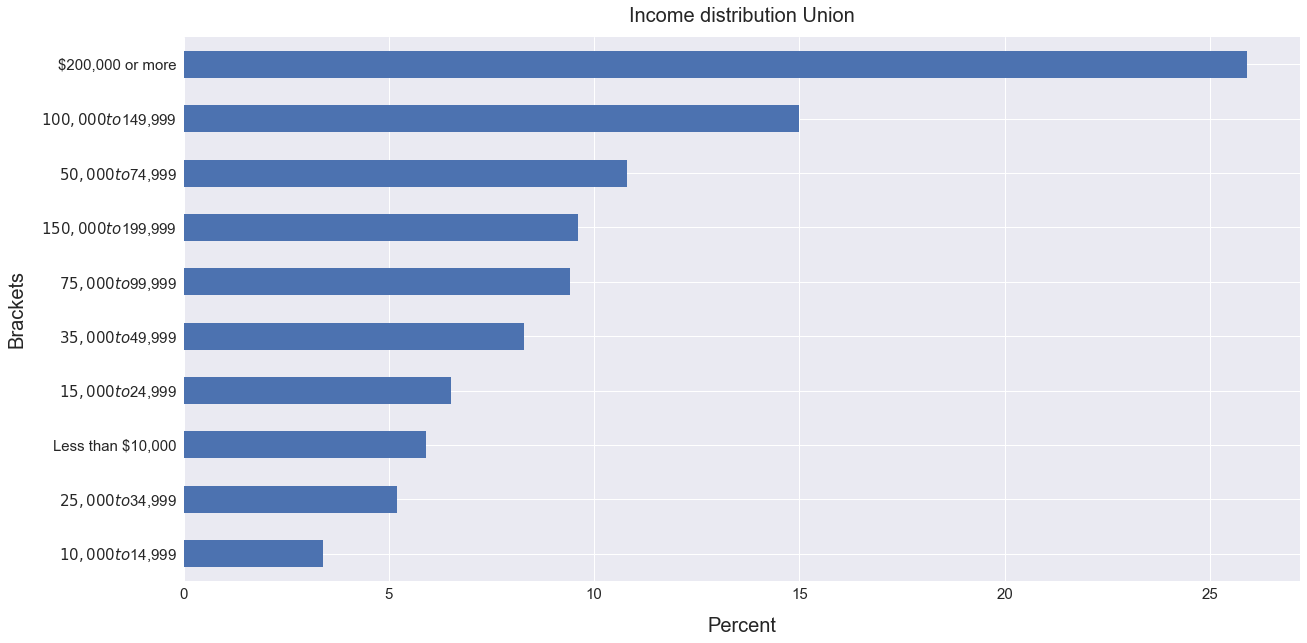

In [218]:
graph(union_income['INCOME AND BENEFITS'], union_income['Percent'])
plt.ylabel("Brackets")
plt.title("Income distribution Union")
plt.tight_layout()
plt.savefig("Income distribution union")